In [88]:
def cutoff_youdens_j_index(fpr, tpr):
    j_scores = tpr-fpr # J = sensivity + specificity - 1
    indices = range(tpr.size)
    j_ordered = sorted(zip(j_scores, indices))
    return j_ordered[-1][1]

In [89]:
import os
import pandas as pd
import torch
import numpy as np

def gather_data(modality_dir):
    score_data_columns = ['model', 'rf', 'TP/FP', 'positive classification rate']
    score_data = pd.DataFrame([], columns = score_data_columns)

    
    models = [o for o in os.listdir(modality_dir)
                    if os.path.isdir(os.path.join(modality_dir,o))]
    for model in models:
        model_dir = os.path.join(modality_dir, model)
        evals = [o for o in os.listdir(model_dir)
                        if os.path.isdir(os.path.join(model_dir,o))]
        
        model_name = model
        if model == 'CBF1_logRegGLM':
            model_name = 'glm(CBF)'
        if model == 'CBV3_logRegGLM':
            model_name = 'glm(CBV)'
        if model == 'MTT2_logRegGLM':
            model_name = 'glm(MTT)'
        if model == 'multi_modal_LogRegGLM':
            model_name = 'glm(multi)'
        if model == 'Tmax0_logRegGLM':
            model_name = 'glm(Tmax)'
        if model == 'Unscaled_customTresholdTmax0':
            continue
        if model == 'Unscaled_Tmax0_6_Treshhold':
            model_name = 'Tmax > 6s'      
            
        for eval_dir in evals:
            files = os.listdir(os.path.join(model_dir, eval_dir))
            for file in files:
                if (file.startswith('scores_') and file.endswith('.npy')):
                    score_path = os.path.join(model_dir, eval_dir, file)
                    scores = torch.load(score_path)

                    # In older versions params were not seperated
                    param_obj = scores
                    if 'params' in scores:
                        param_obj = scores['params']
                    try:
                        rf = np.median(param_obj['rf'])
                    except KeyError:
                        rf = int(file.split('_')[-1].split('.')[0])
                        
                    # not all models were evaluated on rf 6, so skip for now
                    if rf == 6: continue
                    
                    n_experiments = len(scores['test_FPR'])
                    for run in range(n_experiments):
                        index = cutoff_youdens_j_index(scores['test_FPR'][run], scores['test_TPR'][run])
                        best_FPR = scores['test_FPR'][run][index]
                    
                        new_row = pd.DataFrame(np.array([model_name, rf, 'FPR', best_FPR])
                                               .reshape(-1, len(score_data_columns)), columns = score_data_columns)
                        score_data = score_data.append(new_row, ignore_index = True)

                        
                        best_TPR = scores['test_TPR'][run][index]
                    
                        new_row = pd.DataFrame(np.array([model_name, rf, 'TPR', best_TPR])
                                               .reshape(-1, len(score_data_columns)), columns = score_data_columns)
                        score_data = score_data.append(new_row, ignore_index = True)

                        
    score_data['positive classification rate'] = score_data['positive classification rate'].astype(float)                          
    return score_data

                
                
dir = '/Users/julian/stroke_research/pilotBatch_2016_results/server_output/selected_for_article1_13022019/'
score_data = gather_data(dir)
print('Done.')

this is a test
Done.


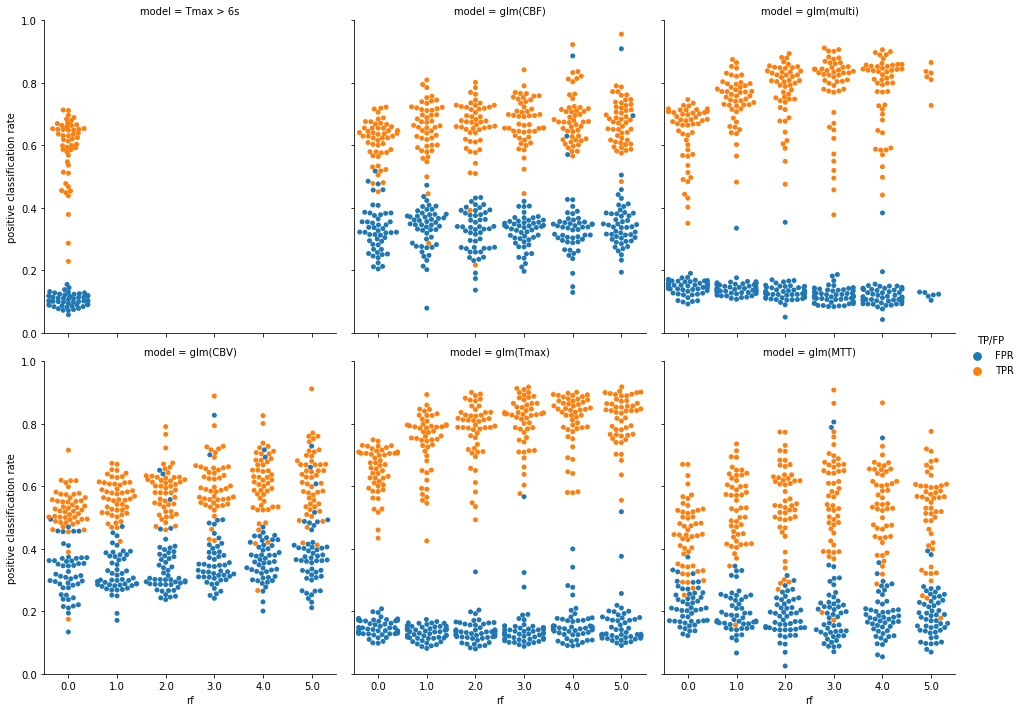

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot FPR and TPR at optimal threshold for every model for every RF
g = sns.catplot(x="rf", y="positive classification rate", hue="TP/FP",
            col="model", col_wrap=3, aspect=.9,
            kind="swarm", data=score_data);

g.set(ylim=(0, 1))
#plt.legend(bbox_to_anchor=(1.5, 0.5), loc=2, borderaxespad=0., fontsize = 'x-large')

fig1 = plt.gcf()
plt.show()
fig1.savefig(os.path.join(dir, 'compare_classification_rate_per_model.svg'), format="svg")